# Training PyTorch Faster R-CNN for Early Smoke Detection on FLAME Aerial Dataset

## **0.** Settings

In [5]:
# !pip install albumentations==0.4.6
# !pip install pycocotools

In [6]:
import sys
sys.path.insert(0,'./detection/')

In [7]:
from torchvision.models.detection.rpn import AnchorGenerator
from albumentations.pytorch.transforms import ToTensorV2
from torchvision.models.detection import FasterRCNN
from torchvision.models import ResNet50_Weights
from engine import train_one_epoch, evaluate
import torchvision.transforms as transform
import matplotlib.pyplot as plt
import albumentations as A
import pandas as pd
import torchvision
import numpy as np
import torch
import cv2
import os

In [8]:
## ===========================
##   GPU
## ===========================

gpu = True

if gpu == True:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

## **1.** Dataset

In [9]:
!ls /home/calvinzhou/py-workspace/a2d2/Faster-RCNN-data/flame_annotated_v6i

README.dataset.txt  README.roboflow.txt  test  train  valid


## **2.** Train and validation sets

In [10]:
# Path for annotations (train and validation)
train_csv_path = '/home/calvinzhou/py-workspace/a2d2/Faster-RCNN-data/flame_annotated_v6i/train_annotations.csv'
valid_csv_path = '/home/calvinzhou/py-workspace/a2d2/Faster-RCNN-data/flame_annotated_v6i/valid_annotations.csv'

# Path for images (train and validation)
train_images = '/home/calvinzhou/py-workspace/a2d2/Faster-RCNN-data/flame_annotated_v6i/train/'
valid_images = '/home/calvinzhou/py-workspace/a2d2/Faster-RCNN-data/flame_annotated_v6i/valid/'

In [11]:
# Train
train_csv = pd.read_csv(train_csv_path)
train_csv.head()

filename  width  height class  \
0  image_601_jpg.rf.013b44a646fef7abf621975c56c4e...    640     640  fire   
1  image_601_jpg.rf.013b44a646fef7abf621975c56c4e...    640     640  fire   
2  image_601_jpg.rf.013b44a646fef7abf621975c56c4e...    640     640  fire   
3  image_601_jpg.rf.013b44a646fef7abf621975c56c4e...    640     640  fire   
4  image_601_jpg.rf.013b44a646fef7abf621975c56c4e...    640     640  fire   

   xmin  ymin  xmax  ymax  
0     0     0     9    92  
1   235    15   296   115  
2   454   355   503   384  
3   432    21   465   121  
4   112   384   206   475

In [12]:
# Validation
valid_csv = pd.read_csv(valid_csv_path)
valid_csv.head()

filename  width  height class  \
0  image_709_jpg.rf.ded7119a8d141d6fd536a66df343f...    640     640  fire   
1  image_709_jpg.rf.ded7119a8d141d6fd536a66df343f...    640     640  fire   
2  image_709_jpg.rf.ded7119a8d141d6fd536a66df343f...    640     640  fire   
3  image_709_jpg.rf.ded7119a8d141d6fd536a66df343f...    640     640  fire   
4  image_1417_jpg.rf.55d657d907ed41e83ba4a12e530f...    640     640  fire   

   xmin  ymin  xmax  ymax  
0   103   225   152   335  
1   455   487   500   579  
2   348   265   392   364  
3   390    60   424   112  
4   483   477   583   560

## **3.** Labels encoding

In [13]:
# Define categories
categories = train_csv['class'].unique()
print(categories)

['fire']


In [16]:
## Encode the categories with integers
## (the train set define the encodings, the other sets have to adapt to that encodings)

# ====================
#   Train set
# ====================
class LabelMap:

    def __init__(self, categories):
        
        self.map_dict = {}
        self.reverse_map_dict = {}

        # Assign to every category an integer (starting from 1)
        for i, cat in enumerate(categories):
            self.map_dict[cat] = i + 1
            self.reverse_map_dict[i] = cat

    def fit(self, df, column):
        df[column] = df[column].map(self.map_dict)
        return df

# ====================
#   Other sets
# ====================
def encode_label(df, column, map_dict):
    df[column] = df[column].map(map_dict)
    return df

In [15]:
# Create an instance of the class
label_map = LabelMap(categories)

In [17]:
# Encode the labels of the train set
train_csv = label_map.fit(train_csv, 'class')
train_csv.head()

filename  width  height  class  \
0  image_601_jpg.rf.013b44a646fef7abf621975c56c4e...    640     640      1   
1  image_601_jpg.rf.013b44a646fef7abf621975c56c4e...    640     640      1   
2  image_601_jpg.rf.013b44a646fef7abf621975c56c4e...    640     640      1   
3  image_601_jpg.rf.013b44a646fef7abf621975c56c4e...    640     640      1   
4  image_601_jpg.rf.013b44a646fef7abf621975c56c4e...    640     640      1   

   xmin  ymin  xmax  ymax  
0     0     0     9    92  
1   235    15   296   115  
2   454   355   503   384  
3   432    21   465   121  
4   112   384   206   475

In [18]:
# Encode the labels of the validation set
valid_csv = encode_label(valid_csv, 'class', label_map.map_dict)
valid_csv.head()

filename  width  height  class  \
0  image_709_jpg.rf.ded7119a8d141d6fd536a66df343f...    640     640      1   
1  image_709_jpg.rf.ded7119a8d141d6fd536a66df343f...    640     640      1   
2  image_709_jpg.rf.ded7119a8d141d6fd536a66df343f...    640     640      1   
3  image_709_jpg.rf.ded7119a8d141d6fd536a66df343f...    640     640      1   
4  image_1417_jpg.rf.55d657d907ed41e83ba4a12e530f...    640     640      1   

   xmin  ymin  xmax  ymax  
0   103   225   152   335  
1   455   487   500   579  
2   348   265   392   364  
3   390    60   424   112  
4   483   477   583   560

## **4.** Prepare the data

In [19]:
class WildFireSmoke_Dataset(torch.utils.data.Dataset):

    def __init__(self, df, image_path, categories, transforms=None, **kwargs):
        super().__init__(**kwargs)
        self.df         = df
        self.image_path = image_path
        self.categories = categories
        self.images     = self.df['filename'].unique()
        self.transforms = transforms

    def __len__(self):
        return len(self.images)

    #------------------------------------------------------------------------ Extract 'idx'-th item ---------#
    def __getitem__(self, idx):                                                                              #
                                                                                                             #
        # Define the 'idx'-th image path                                                                     #
        image_file = os.path.join(self.image_path, self.images[idx])                                         #
                                                                                                             #
        # Get the image                                                                                      #
        img = cv2.imread(image_file)                                                                         #
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)                                                           #
        img = img.astype(np.float32)                                                                         #
        img = img/255.0                                                                                      #
                                                                                                             #
        # Get the box/s coordinates for each element                                                         #
        image_data = self.df[self.df['filename'] == self.images[idx]]                                        #      
        xmins = image_data['xmin'].values                                                                    #
        ymins = image_data['ymin'].values                                                                    #
        xmaxs = image_data['xmax'].values                                                                    #
        ymaxs = image_data['ymax'].values                                                                    #
                                                                                                             #
        # Convert everything into a torch.Tensor                                                             #
        boxes = torch.as_tensor(np.stack([xmins, ymins, xmaxs, ymaxs], axis=1), dtype=torch.float32)         #
        labels = torch.as_tensor(image_data['class'].values, dtype=torch.int64)                              #
        image_id = torch.tensor([idx])                                                                       #
                                                                                                             #
        # Calculate the area/s of the box/s                                                                  #
        areas = (boxes[:,3] - boxes[:,1]) * (boxes[:,2] - boxes[:,0])                                        #
        areas = torch.as_tensor(areas, dtype=torch.float32)                                                  #
                                                                                                             #
        # Format                                                                                             #
        iscrowd = torch.zeros((len(labels),), dtype=torch.int64)                                             #
                                                                                                             #
        # Target (dict) definition                                                                           #
        target = {}                                                                                          #
        target['boxes']    = boxes                                                                           #
        target['labels']   = labels                                                                          #
        target['image_id'] = image_id                                                                        #
        target['area']     = areas                                                                           #
        target['iscrowd']  = iscrowd                                                                         #
                                                                                                             #
        # Data transformations                                                                               # 
        if self.transforms is not None:                                                                      #
                                                                                                             #
            # Define transformation                                                                          #
            transformed = self.transforms(image=img, bboxes=boxes, labels=labels)                            #
                                                                                                             #
            # Image transformation                                                                           #
            img = transformed['image']                                                                       # 
                                                                                                             #
            # Target transformation                                                                          #
            target['boxes'] = torch.as_tensor(transformed['bboxes'], dtype=torch.float32)                    #
                                                                                                             #
        return torch.as_tensor(img, dtype=torch.float32), target                                             #
    #--------------------------------------------------------------------------------------------------------#

    def get_height_and_width(self, image):
        image_data = self.df.loc[self.df['filename'] == image]
        return image_data['width'].values[0], image_data['height'].values[0]

In [20]:
# Train set transformations
transform_train = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    ToTensorV2(p=1)], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

# Validation set transformations
transform_valid = A.Compose([
    ToTensorV2(p=1)], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

In [21]:
# Define a custom collate: collate_fn
# (it collates the input samples into a batch to then pass the whole batch to the data loader iterator)

def collate_fn(batch):
    return tuple(zip(*batch))

In [22]:
# Finally import train and validation
train_dataset = WildFireSmoke_Dataset(train_csv, train_images, categories, transform_train)
valid_dataset = WildFireSmoke_Dataset(valid_csv, valid_images, categories, transform_valid)

data_loader_train = torch.utils.data.DataLoader(
        train_dataset, 
        batch_size  = 4, 
        shuffle     = True, 
        num_workers = 2,
        collate_fn  = collate_fn)
    
data_loader_valid = torch.utils.data.DataLoader(
        valid_dataset, 
        batch_size  = 4, 
        shuffle     = False, 
        num_workers = 2,
        collate_fn  = collate_fn)

## **5.** Plot images and boxes

In [23]:
def plot_images(images, targets):

    max_images = 4
    count_imgs = 0

    for image, target in zip(images, targets):

        if count_imgs == max_images:
            break

        count_imgs += 1

        # Get the image and the boxes in the right format
        sample = image.permute(1,2,0).cpu().numpy()
        boxes  = target['boxes'].cpu().numpy().astype(np.int32)

        # Define the plot
        fig, ax = plt.subplots(1, 1, figsize=(10, 8))

        text = 'fire'

        # Plot the boxes
        for box in boxes:
            cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (1,0,0), 2)

            text_size, _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
            text_width = text_size[0] + 10

            cv2.rectangle(sample, (box[0], box[1] - 20), (box[0] + text_width, box[1]), (1, 0, 0), -1)

            # Display label and confidence on the image
            cv2.putText(sample, text, (int(box[0]) + 5, int(box[1]) - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, cv2.LINE_AA)

        # Additional
        ax.set_axis_off()
        ax.imshow((sample * 255).astype(np.uint8))

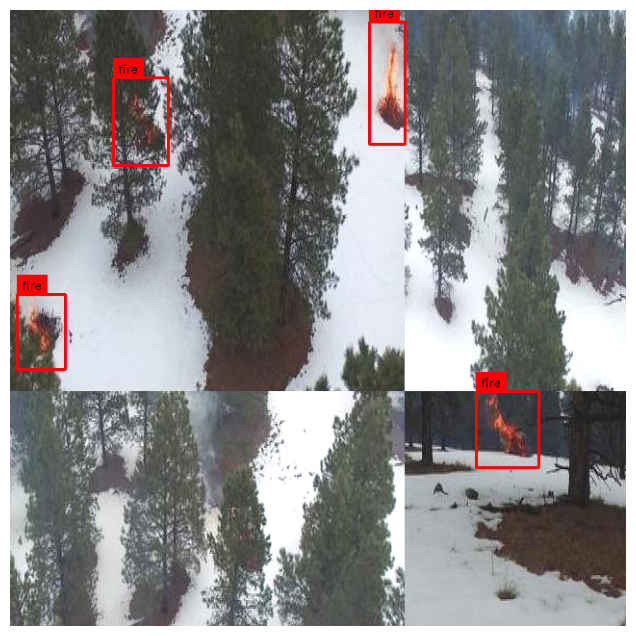

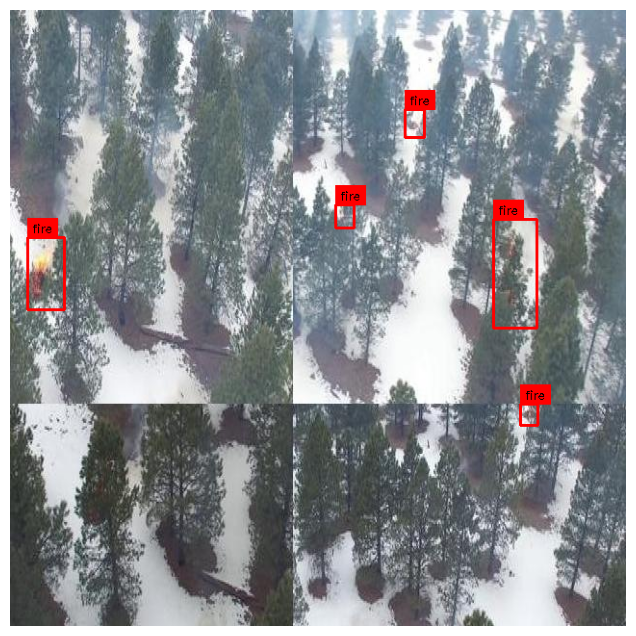

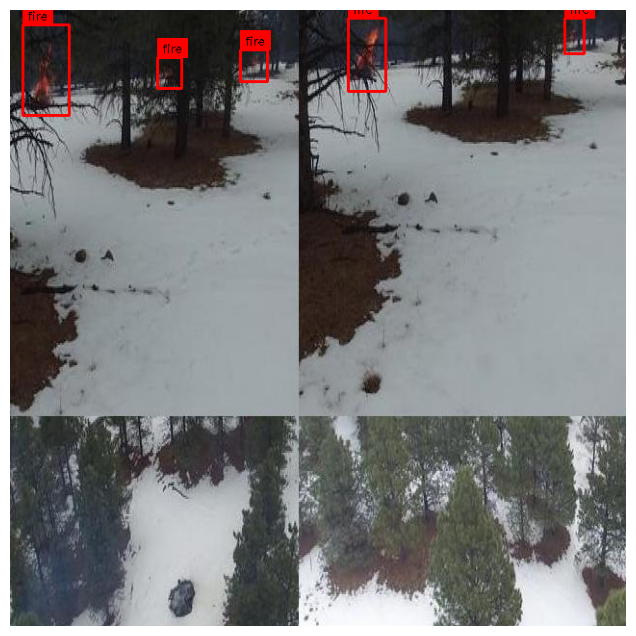

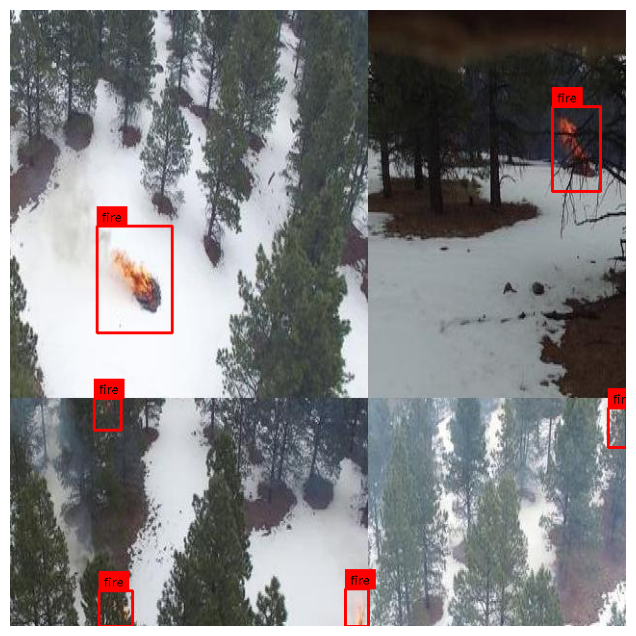

In [24]:
# Train set - images and boxes
images, targets = next(iter(data_loader_train))
plot_images(images, targets)

## **6.** Model definition

### **6.1.** Import the pre-trained model

Available models, pre-trained on COCO dataset, at https://pytorch.org/vision/master/models/faster_rcnn.html.

In [25]:
# Transfer learning: load a model pre-trained on COCO
detection_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

/home/calvinzhou/miniconda3/envs/py39-frcnn/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/calvinzhou/miniconda3/envs/py39-frcnn/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### **6.2.** Adjust the classifier

In [26]:
## Replace the classifier with a new one, that has num_classes which is user-defined

# Define the number of classes (len(categories) + 'background')
num_classes = len(categories) + 1

# Get the number of input features for the classifier
in_features = detection_model.roi_heads.box_predictor.cls_score.in_features

# Replace the pre-trained head with a new one
detection_model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

### **6.3.** Move the model to `device`

In [27]:
# Move the model to 'device'
detection_model = detection_model.to(device)

## **7.** Training

In [28]:
def training(model, train_loader, val_loader, epochs):
    
    # Optimizer and learning rate
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    
    # Adapter
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    for epoch in range(epochs):

        # Train for one epoch, printing every 'print_freq'
        train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=len(data_loader_train))

        # Update the learning rate
        lr_scheduler.step()
        
        # Evaluate on the validation set
        evaluate(model, val_loader, device=device)

training(detection_model, data_loader_train, data_loader_valid, epochs=20)

Epoch: [0]  [  0/117]  eta: 0:02:51  lr: 0.000048  loss: 1.1641 (1.1641)  loss_classifier: 0.7575 (0.7575)  loss_box_reg: 0.1187 (0.1187)  loss_objectness: 0.2721 (0.2721)  loss_rpn_box_reg: 0.0158 (0.0158)  time: 1.4627  data: 0.1241  max mem: 2631
Epoch: [0]  [116/117]  eta: 0:00:00  lr: 0.005000  loss: 0.4770 (0.6141)  loss_classifier: 0.1220 (0.1861)  loss_box_reg: 0.2996 (0.3140)  loss_objectness: 0.0234 (0.0826)  loss_rpn_box_reg: 0.0144 (0.0312)  time: 0.1888  data: 0.0066  max mem: 2790
Epoch: [0] Total time: 0:00:23 (0.1989 s / it)
creating index...
index created!
Test:  [0/5]  eta: 0:00:00  model_time: 0.0928 (0.0928)  evaluator_time: 0.0090 (0.0090)  time: 0.1745  data: 0.0671  max mem: 2790
Test:  [4/5]  eta: 0:00:00  model_time: 0.0777 (0.0893)  evaluator_time: 0.0089 (0.0080)  time: 0.1195  data: 0.0183  max mem: 2790
Test: Total time: 0:00:00 (0.1224 s / it)
Averaged stats: model_time: 0.0777 (0.0893)  evaluator_time: 0.0089 (0.0080)
Accumulating evaluation results...
DO

In [29]:
# ======================================
#   SAVE THE MODEL
# ======================================

# Path for saving the best model
path_best_model = '/home/calvinzhou/py-workspace/a2d2/Faster-RCNN-data/flame_annotated_v6i/'

# Save the model
torch.save(detection_model.state_dict(), path_best_model + 'detection_model.pt')

## **8.** Prediction

In [30]:
# Path of the best model
path_best_model = '/home/calvinzhou/py-workspace/a2d2/Faster-RCNN-data/flame_annotated_v6i/'

# Load the model
detection_model.load_state_dict(torch.load(path_best_model + 'detection_model.pt'))

<All keys matched successfully>

In [32]:
# Path for annotations (test)
test_csv_path = '/home/calvinzhou/py-workspace/a2d2/Faster-RCNN-data/flame_annotated_v6i/test_annotations.csv'

# Path for images (test)
test_images = '/home/calvinzhou/py-workspace/a2d2/Faster-RCNN-data/flame_annotated_v6i/test/'

# Test
test_csv = pd.read_csv(test_csv_path)

# Encode the labels of the test set
test_csv = encode_label(test_csv, 'class', label_map.map_dict)

# Test set transformations
transform_test = A.Compose([
    ToTensorV2(p=1)], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

# Finally import test
test_dataset = WildFireSmoke_Dataset(test_csv, test_images, categories, transform_test)

data_loader_test = torch.utils.data.DataLoader(
        test_dataset, 
        batch_size  = 4, 
        shuffle     = True, 
        num_workers = 2,
        collate_fn  = collate_fn)

In [33]:
def view_sample(loader, model, device, threshold):

    images, targets = next(iter(loader))
    images = list(img.to(device) for img in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    
    boxes_gt = targets[0]['boxes'].cpu().numpy().astype(np.int32)
    sample = images[0].permute(1,2,0).cpu().numpy()
    
    model.to(device)
    model.eval()
    cpu_device = torch.device('cpu')

    outputs = model(images)
    outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    # Paint ground_truth boxes (blue)
    for box in boxes_gt:
        color_blue = (0,0,1)
        cv2.rectangle(sample,
              (box[0], box[1]),
              (box[2], box[3]),
              color_blue, 2)
             
    boxes = outputs[0]['boxes'].data.cpu().numpy()
    scores = outputs[0]['scores'].data.cpu().numpy()
          
    # Paint predicted boxes (red)
    pred_box_count = 0
    for box, p in zip(boxes, scores):        
        if p > threshold:
            pred_box_count += 1
            color_red = (1,0,0)
            pt1 = (int(box[0]), int(box[1]))
            pt2 = (int(box[2]), int(box[3]))
            cv2.rectangle(sample, pt1, pt2, color_red, 2)

            # Print label and confidence score
            label = outputs[0]['labels'].data.cpu().numpy()
            confidence = str(round(p, 2))
            text = f'fire {confidence}'

            text_size, _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
            text_width = text_size[0] + 10

            cv2.rectangle(sample, (pt1[0], pt1[1] - 20), (pt1[0] + text_width, pt1[1]), color_red, -1)

            # Display label and confidence on the image
            cv2.putText(sample, text, (int(box[0]) + 5, int(box[1]) - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, cv2.LINE_AA)

    # print(f'Predicted {pred_box_count} BBoxes (blue); Number of GT BBoxes (red) : {len(boxes_gt)}')
    ax.set_axis_off()
    ax.imshow((sample * 255).astype(np.uint8))      

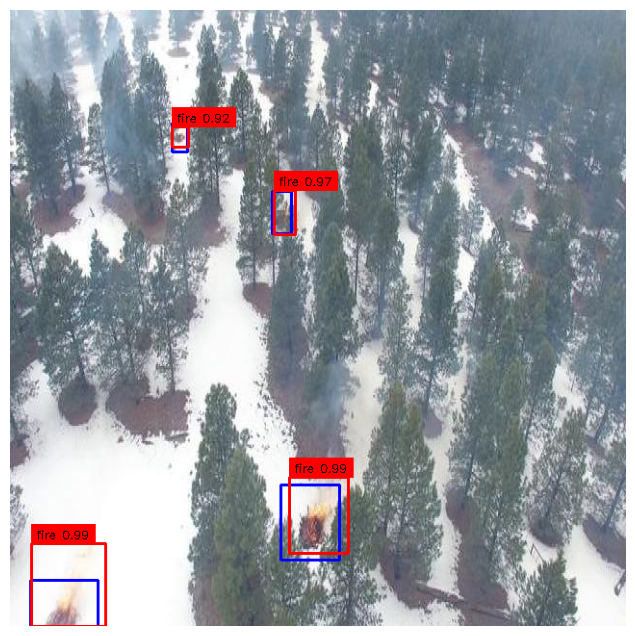

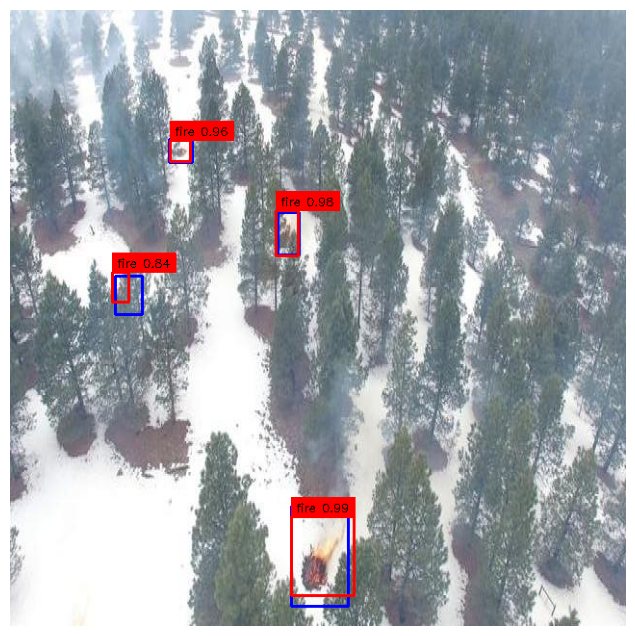

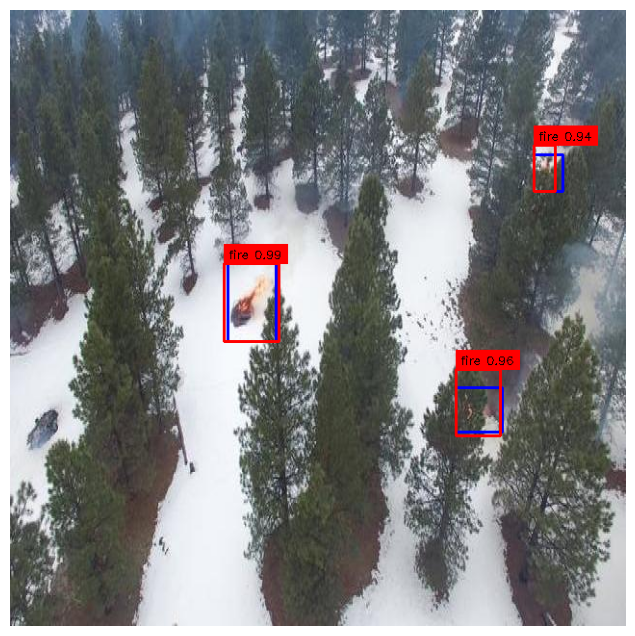

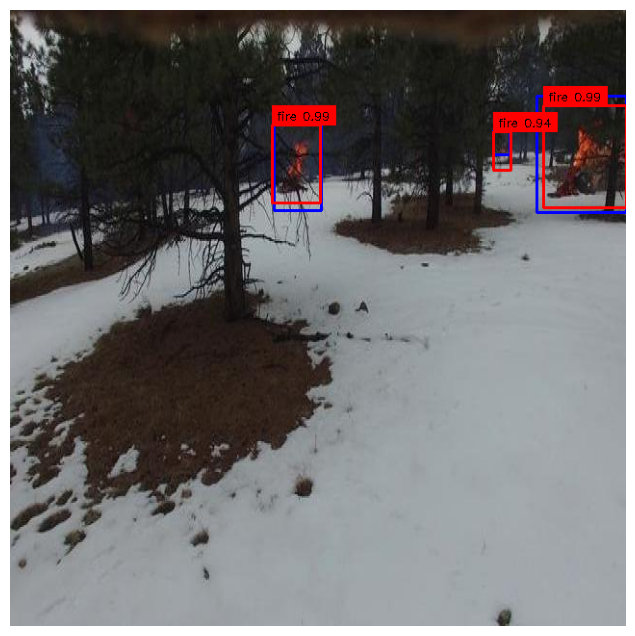

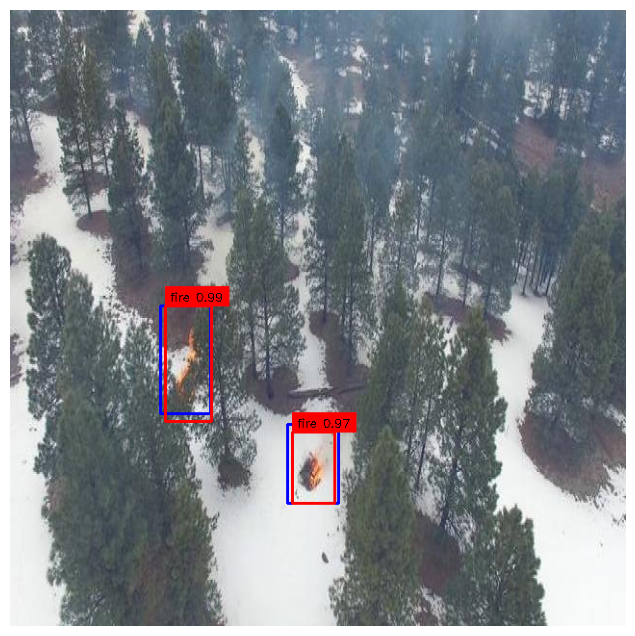

In [35]:
# Show predictions
for i in range(5):
    view_sample(data_loader_test, detection_model, device, 0.6)

## **9.** Evaluation Metrics

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

# Lists to store true positives, false negatives, true negatives, and false positives for each object
true_positives = 0
false_negatives = 0
true_negatives = 0
false_positives = 0

# Iterate over the validation dataset
for i in range(len(test_dataset)):
    image, labels = test_dataset[i]

    # Move image to device
    image = image.to(device)

    # Move labels to device
    labels = {k: v.to(device) for k, v in labels.items()}

    # Forward pass to obtain predictions
    with torch.no_grad():
        prediction = detection_model([image])

    # Extract ground truth and predicted labels
    gt_labels = labels['labels'].cpu().numpy() if 'labels' in labels else []
    pred_labels = prediction[0]['labels'].cpu().numpy() if 'labels' in prediction[0] else []

    # Iterate over each ground truth object
    for gt_label in gt_labels:
        # Check if the class is present in the ground truth
        gt_class_present = gt_label != 0

        # Check if the class is detected
        pred_class_present = any(label == gt_label for label in pred_labels)

        # Update counts based on different scenarios
        if gt_class_present and pred_class_present:
            true_positives += 1
        elif gt_class_present and not pred_class_present:
            false_negatives += 1

    # Iterate over each predicted object
    for pred_label in pred_labels:
        # Check if the predicted class is not in the ground truth (false positive)
        if pred_label != 0 and pred_label not in gt_labels:
            false_positives += 1

# Calculate precision, recall, and F1 score for each object
precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Print precision, recall, F1 score, and other metrics for each object
print("True Positives:", true_positives)
print("True Negatives:", true_positives)
print("False Negatives:", false_negatives)
print("False Positives:", false_positives)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


True Positives: 56
True Negatives: 56
False Negatives: 0
False Positives: 0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


In [37]:
evaluate(detection_model, data_loader_test, device=device)

creating index...
index created!
Test:  [0/5]  eta: 0:00:00  model_time: 0.0817 (0.0817)  evaluator_time: 0.0029 (0.0029)  time: 0.1545  data: 0.0660  max mem: 2790
Test:  [4/5]  eta: 0:00:00  model_time: 0.0782 (0.0848)  evaluator_time: 0.0024 (0.0024)  time: 0.1081  data: 0.0175  max mem: 2790
Test: Total time: 0:00:00 (0.1111 s / it)
Averaged stats: model_time: 0.0782 (0.0848)  evaluator_time: 0.0024 (0.0024)
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.412
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.916
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.275
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.284
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.451
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.499
 Average Recall     (AR) @[ IoU=0.50